In [72]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output

import folium
from folium.plugins import MarkerCluster

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV

# App

In [7]:
df = pd.read_csv('Brazilian_ecommerce (merged).csv', index_col = 0)

In [8]:
df['sales'] = df['price'] * df['items_count']

for col in df.columns:
    if col.endswith('_timestamp') or col.endswith('_date') or col.endswith('_at'):
        try:
            if col.endswith('_timestamp'):
                df[col] = pd.to_datetime(df[col])
            elif col.endswith('_date') or col.endswith('_at'):
                df[col] = pd.to_datetime(df[col])
                # df[col] = pd.to_datetime(df[col]).dt.to_period('M')
        except Exception as e:
            print(f'Error mengonversi kolom {col}: {e}')
            pass

display(df.head())
display(df.info())

,order_id,items_count,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,shipping_limit_date,price,freight_value,product_cat_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,sales
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04,2017-05-12,2017-05-15,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03,239.90,19.93,pet_shop,56,239,2,30000,50,30,40,1,credit_card,3,259,4,2017-05-13,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,239.90
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16,2018-01-22,2018-02-05,5b51032eddd242adc84c38acab88f23d,2018-01-18,199.00,17.87,furniture_decor,59,695,2,3050,33,13,33,1,credit_card,5,216,5,2018-01-23,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10,2018-08-14,2018-08-20,9d7a1d34a5052409006425275ba1c2b4,2018-08-15,12.99,12.79,perfumery,42,480,1,200,16,10,15,1,credit_card,2,25,4,2018-08-15,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16,2017-03-01,2017-03-17,df560393f3a51e74553ab94004ba5c87,2017-02-13,199.90,18.14,garden_tools,59,409,1,3750,35,40,30,1,credit_card,3,218,5,2017-03-02,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438,199.90
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17,2017-05-22,2017-06-06,6426d21aca402a131fc0a5d0960a3c90,2017-05-23,21.90,12.69,housewares,36,558,1,450,24,8,15,1,boleto,1,34,4,2017-05-23,2017-05-24 19:00:09,85c835d128beae5b4ce8602c491bf385,38017,uberaba,MG,-19.740324,-47.925353,14091,ribeirao preto,SP,-21.189678,-47.788330,21.90


<class 'pandas.core.frame.DataFrame'>
Index: 93100 entries, 1 to 96459
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93100 non-null  object        
 1   items_count                    93100 non-null  int64         
 2   customer_id                    93100 non-null  object        
 3   order_status                   93100 non-null  object        
 4   order_purchase_timestamp       93100 non-null  datetime64[ns]
 5   order_approved_at              93100 non-null  datetime64[ns]
 6   order_delivered_carrier_date   93100 non-null  datetime64[ns]
 7   order_delivered_customer_date  93100 non-null  datetime64[ns]
 8   order_estimated_delivery_date  93100 non-null  datetime64[ns]
 9   seller_id                      93100 non-null  object        
 10  shipping_limit_date            93100 non-null  datetime64[ns]
 11  price               

None

In [133]:
class SellerAnalysis:
    def __init__(self, seller_id, df):
        self.seller_id = seller_id
        self.df = df
        self.seller_data = df[df['seller_id'] ==  seller_id].copy()

        if self.seller_data.empty:
            print(f'Tidak ada data untuk seller ID {self.seller_id}.')
            self.seller_city = None
            self.seller_prod_category = None
        else:
            self.seller_city = self.seller_data.seller_city.unique()[0]
            self.seller_prod_category = self.seller_data.product_cat_name.value_counts().index.to_list()

    def plot_sales(self):
        if self.seller_city is None:
            return

        while True:
            # Display menu for product category selection
            print('Choose product category for sales plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            # Get user input
            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting sales plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's product sales in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] ==  selected_category]
                    category_sales_seller = category_data_seller.groupby('order_purchase_timestamp')['sales'].sum().resample('M').mean()

                    # All sellers' sales in the selected category and city
                    category_data_all = self.df[(self.df['product_cat_name'] ==  selected_category) & (self.df['seller_city'] ==  self.seller_city)]
                    category_sales_all = category_data_all.groupby('order_purchase_timestamp')['sales'].sum().resample('M').mean()

                    # Plotting
                    plt.figure(figsize = (10, 6))
                    plt.plot(category_sales_seller.index, category_sales_seller, 
                             label = f'Seller {self.seller_id}',
                             linewidth = 2)
                    plt.plot(category_sales_all.index, category_sales_all, label = f'All Sellers in {self.seller_city}')

                    plt.title(f'Sales Comparison for Product: {selected_category}')
                    plt.xlabel('Date')
                    plt.ylabel('Total Sales (Price)')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')

    def plot_quantity(self):
        if self.seller_city is None:
            return

        while True:
            print('Choose product category for quantity plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting quantity plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's quantity sold in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] == selected_category]
                    category_quantity_seller = category_data_seller.groupby('order_purchase_timestamp')['items_count'].sum().resample('M').sum()

                    # All sellers' quantity sold in the selected category and city
                    category_data_all = self.df[(self.df['product_cat_name'] ==  selected_category) & (self.df['seller_city'] ==  self.seller_city)]
                    category_quantity_all = category_data_all.groupby('order_purchase_timestamp')['items_count'].sum().resample('M').sum()

                    # Plotting
                    plt.figure(figsize = (10, 6))
                    plt.plot(category_quantity_seller.index, category_quantity_seller, 
                             label = f'Seller {self.seller_id}',
                             linewidth = 3)
                    plt.plot(category_quantity_all.index, category_quantity_all, 
                             label = f'All Sellers in {self.seller_city}')

                    plt.title(f'Quantity Comparison for Product: {selected_category}')
                    plt.xlabel('Date')
                    plt.ylabel('Number of Items Sold')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')

    def plot_ratings(self):
        if self.seller_city is None:
            return

        while True:
            print('Choose product category for ratings plot:')
            for i, product in enumerate(self.seller_prod_category, 1):
                print(f'{i}. {product}')
            print(f'{len(self.seller_prod_category) + 1}. Exit')

            try:
                choice = int(input('Enter the number of your choice: '))
                if choice ==  len(self.seller_prod_category) + 1:
                    print('Exiting ratings plot...')
                    break
                elif 1 <= choice <= len(self.seller_prod_category):
                    selected_category = self.seller_prod_category[choice - 1]

                    # Seller's ratings in the selected category
                    category_data_seller = self.seller_data[self.seller_data['product_cat_name'] ==  selected_category]
                    
                    # rating_5 = category_data_seller[category_data_seller['review_score'] == 5].shape[0]
                    # rating_4 = category_data_seller[category_data_seller['review_score'] == 4].shape[0]
                    # rating_1_3 = category_data_seller[category_data_seller['review_score'].between(1, 3)].shape[0]
                    
                    rating_3_5 = category_data_seller[category_data_seller['review_score'].between(3, 5)].shape[0]
                    rating_1_2 = category_data_seller[category_data_seller['review_score'].between(1, 2)].shape[0]

                    # labels = ['5', '4', '1-3']
                    # sizes = [rating_5, rating_4, rating_1_3]
                    # colors = ['g', 'b', 'r']
                    
                    sizes = [rating_3_5, rating_1_2]
                    labels = ['Good', 'Bad']
                    colors = ['g', 'r']
                    
                    # Exploding the slice for "1-3" rating to separate it
                    # explode = (0, 0, 0.1) 
                    explode = (0, 0.2)

                    # Plotting Pie Chart
                    plt.figure(figsize = (8, 6), facecolor = 'white')  # Set background color to white
                    plt.pie(sizes, labels = labels, colors = colors, explode = explode,
                            autopct = '%1.1f%%', startangle = 90, textprops = {'fontsize': 14},  
                            wedgeprops = {'edgecolor': 'black'},  
                            )

                    plt.title(f'Review Ratings Distribution for {selected_category}\n(Seller {self.seller_id})',
                              fontsize = 12)
                    
                    # Equal aspect ratio ensures the pie chart is drawn as a circle
                    plt.axis('equal')  
                    plt.show()
                else:
                    print('Invalid choice, please try again.')
            except ValueError:
                print('Please enter a valid number.')
    
    def map_customer_locations(self):
        customer_locations = self.seller_data[['customer_lat', 'customer_lng', 'sales', 'product_cat_name']].dropna()

        if not customer_locations.empty:
            
            # Center the map on the average customer location
            m = folium.Map(location = [customer_locations['customer_lat'].mean(), customer_locations['customer_lng'].mean()], zoom_start = 8)

            marker_cluster = MarkerCluster().add_to(m)

            for _, row in customer_locations.iterrows():
                folium.Marker(
                    location = [row['customer_lat'], row['customer_lng']],
                    popup = f'Total Sales: {row.sales:.2f}<br>Product Category: {row.product_cat_name}',
                    icon = folium.Icon(color = 'green')
                ).add_to(marker_cluster)

            display(m)
        else:
            print('There is no customer location data for this seller.')

In [109]:
df.sample(5).seller_id

82282    54a1852d1b8f10312c55e906355666ee
16307    02dcd3e8e25bee036e32512bcf175493
3528     4992e76a42cb3aad7a7047e0d3d7e729
18530    5b67882648febfb6e1225e6ad7164f6b
2160     4a3ca9315b744ce9f8e9374361493884
Name: seller_id, dtype: object

In [137]:
# sa = SellerAnalysis('5160d23075764e18e07c1f4a87fad743', df)
# sa = SellerAnalysis('00ee68308b45bc5e2660cd833c3f81cc', df)
# sa = SellerAnalysis('1430239a858e7682bbc43b20758af153', df)

sa = SellerAnalysis('4a3ca9315b744ce9f8e9374361493884', df)

Choose product category for ratings plot:
1. bed_bath_table
2. home_confort
3. furniture_decor
4. toys
5. home_comfort_2
6. baby
7. cool_stuff
8. Exit


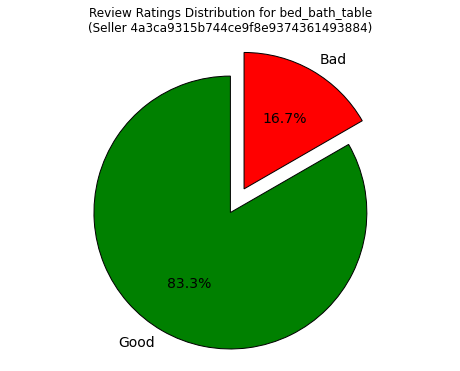

Choose product category for ratings plot:
1. bed_bath_table
2. home_confort
3. furniture_decor
4. toys
5. home_comfort_2
6. baby
7. cool_stuff
8. Exit
Exiting ratings plot...


In [144]:
# display(sa.df.head())

# sa.plot_sales()
# sa.plot_quantity()
sa.plot_ratings()
# sa.map_customer_locations()

In [138]:
data = sa.seller_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 12 to 96441
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       1704 non-null   object        
 1   items_count                    1704 non-null   int64         
 2   customer_id                    1704 non-null   object        
 3   order_status                   1704 non-null   object        
 4   order_purchase_timestamp       1704 non-null   datetime64[ns]
 5   order_approved_at              1704 non-null   period[M]     
 6   order_delivered_carrier_date   1704 non-null   period[M]     
 7   order_delivered_customer_date  1704 non-null   period[M]     
 8   order_estimated_delivery_date  1704 non-null   period[M]     
 9   seller_id                      1704 non-null   object        
 10  shipping_limit_date            1704 non-null   period[M]     
 11  price               

In [118]:
temp_df.payment_type.value_counts()

payment_type
credit_card    1335
boleto          290
voucher          60
debit_card       19
Name: count, dtype: int64

# **Machine Learning**

In [55]:
data = df.copy()
        
display(data.head(2))
display(data.info())

,order_id,items_count,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,shipping_limit_date,price,freight_value,product_cat_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,sales
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04,2017-05-12,2017-05-15,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03,239.9,19.93,pet_shop,56,239,2,30000,50,30,40,1,credit_card,3,259,4,2017-05-13,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,239.9
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16,2018-01-22,2018-02-05,5b51032eddd242adc84c38acab88f23d,2018-01-18,199.0,17.87,furniture_decor,59,695,2,3050,33,13,33,1,credit_card,5,216,5,2018-01-23,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,199.0


<class 'pandas.core.frame.DataFrame'>
Index: 93100 entries, 1 to 96459
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93100 non-null  object        
 1   items_count                    93100 non-null  int64         
 2   customer_id                    93100 non-null  object        
 3   order_status                   93100 non-null  object        
 4   order_purchase_timestamp       93100 non-null  datetime64[ns]
 5   order_approved_at              93100 non-null  datetime64[ns]
 6   order_delivered_carrier_date   93100 non-null  datetime64[ns]
 7   order_delivered_customer_date  93100 non-null  datetime64[ns]
 8   order_estimated_delivery_date  93100 non-null  datetime64[ns]
 9   seller_id                      93100 non-null  object        
 10  shipping_limit_date            93100 non-null  datetime64[ns]
 11  price               

None

### 1. **Feature Engineering**

#### Manual

> Handling Datetime Columns
1. `shpping_time`  --> (Order Deliver Carrier Date - Order Deliver Customer Date)
2. `estimated_shippimg_time` --> Order Deliver Carrier Date - Order Estimated Delivery Date
3. `limit_shipping_time` --> Order Deliver Carrier Date - Shipping Limit Date

> Drop All Columns with suffix _id

In [56]:
# Count shipping time differencing
data['shipping_time']           = abs(data['order_delivered_carrier_date'] - data['order_delivered_customer_date']).dt.days
data['estimated_shipping_time'] = abs(data['order_delivered_carrier_date'] - data['order_estimated_delivery_date']).dt.days
data['limit_shipping_time']     = abs(data['order_delivered_carrier_date'] - data['shipping_limit_date']).dt.days

# Drop datetime columns

datetime_cols = [col for col in data.columns if col.endswith(('_timestamp', '_at', '_date'))]
data.drop(columns = datetime_cols, inplace = True)

In [57]:
# Take All Numerical Cols

num_cols = data.select_dtypes(include = [int, float]).columns
num_cols

Index(['items_count', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_installments', 'payment_value',
       'review_score', 'customer_zip_code_prefix', 'customer_lat',
       'customer_lng', 'seller_zip_code_prefix', 'seller_lat', 'seller_lng',
       'sales', 'shipping_time', 'estimated_shipping_time',
       'limit_shipping_time'],
      dtype='object')

In [58]:
# Drop Columns with suffix _id
cols_to_drop = [col for col in data.columns if col.endswith('_id')]
print(cols_to_drop)
data.drop(columns = cols_to_drop, inplace = True)

other_col_type = data.select_dtypes(exclude = [int, float])

print('Object Columns Data Unique Count:')
for i in other_col_type.columns:
    print(f'{i} : {len(other_col_type[i].unique())}')

['order_id', 'customer_id', 'seller_id', 'customer_unique_id']
Object Columns Data Unique Count:
order_status : 2
product_cat_name : 74
payment_type : 4
customer_city : 3994
customer_state : 27
seller_city : 523
seller_state : 21


#### Encoding

1. One Hot Encoding

> One-Hot Encoding transforms categorical variables into a binary matrix representation. For each category in a variable, a new binary column is created. If the category is present, the column has a value of 1; otherwise, it has a value of 0.

2. Category Encoding

> Category Encoding (often referred to as Label Encoding) assigns a unique integer to each category in a categorical feature. This method is simple and maintains the order of categories if applicable, but it can introduce unintended ordinal relationships.

3. Frequency Encoding

> Frequency Encoding replaces each category with the frequency (or count) of its occurrences in the dataset. This method captures the importance of categories based on how often they appear.

In [59]:
# One Hot Encoding

target_one_hot = ['order_status', 'payment_type']

encoder = OneHotEncoder(sparse = False)
encoded_features = encoder.fit_transform(data[target_one_hot])

one_hot_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out(target_one_hot)).astype(int)

data = pd.concat([data.reset_index(drop = True), one_hot_df], axis = 1)

C:\Users\benjamin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
# Category Encoding

target_cat_encode = ['product_cat_name', 'seller_state']
encoder = ce.TargetEncoder(cols = target_cat_encode)

data[target_cat_encode] = encoder.fit_transform(data[target_cat_encode], data['sales'])

In [61]:
# Frequency Encoding

for cols in ['customer_city', 'seller_state']:
    freq_map = data[cols].value_counts().to_dict()
    data[f'{cols}_freq'] = data[cols].map(freq_map)

In [62]:
cols_to_drop = [col for col in other_col_type if col not in target_cat_encode]
data.drop(columns = cols_to_drop, inplace = True)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93100 entries, 0 to 93099
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   items_count                 93100 non-null  int64  
 1   price                       93100 non-null  float64
 2   freight_value               93100 non-null  float64
 3   product_cat_name            93100 non-null  float64
 4   product_name_lenght         93100 non-null  int64  
 5   product_description_lenght  93100 non-null  int64  
 6   product_photos_qty          93100 non-null  int64  
 7   product_weight_g            93100 non-null  int64  
 8   product_length_cm           93100 non-null  int64  
 9   product_height_cm           93100 non-null  int64  
 10  product_width_cm            93100 non-null  int64  
 11  payment_sequential          93100 non-null  int64  
 12  payment_installments        93100 non-null  int64  
 13  payment_value               931

### 2. Feature Selection

> Variance

Variance is a statistical measure that indicates how far values in a dataset deviate from their mean. A higher variance signifies greater variation among the values in the dataset.

Variance Threshold

VarianceThreshold is a package from the `sklearn.feature_selection`, used to remove features with low variance. This aids in selecting more relevant features and reducing the dimensionality of the dataset.

In [40]:
variance = data.var().round(1)
variance_filter = variance.keys().to_list()

# Manual Variance Threshold
select_features = [col for col in variance_filter if variance[col] >= 0.1]

In [66]:
data = data[select_features]

### 3. Hyperparameter Tuning

1. `Elbow Method`

> Suitable for Determining the Number of Clusters: The Elbow Method is a common technique used to identify the optimal number of clusters in K-Means. This method involves measuring the total **within-cluster sum of squares (WCSS)**  for various cluster counts and then looking for the "elbow" point on the plot.

2. `Grid Search CV`

> Suitable for Hyperparameter Tuning: GridSearchCV is used to find the best combination of hyperparameters for a model, including **K-Means**. This can include various cluster counts, initialization methods, and more.

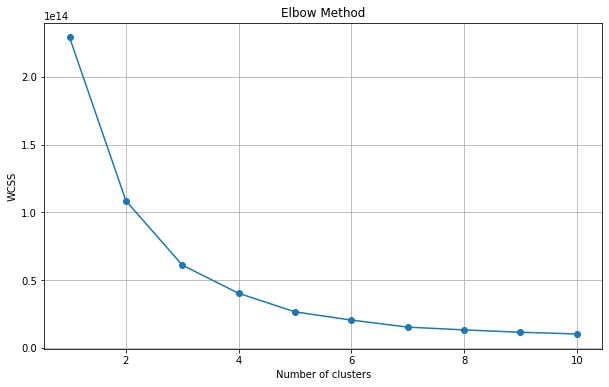

In [95]:
# Elbow Method

X = data.values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (10, 6))
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [43]:
# Grid Search

optimal_clusters = 4

param_grid = {
    'n_clusters': [optimal_clusters],
    'init': ['k-means++', 'random'],
    'max_iter': list(range(10, 101, 10)),
    'n_init': [10, 20]
}

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

kmeans = KMeans()
grid_search = GridSearchCV(estimator = kmeans, param_grid = param_grid, cv = 3, scoring = silhouette_scorer)

grid_search.fit(X)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'init': 'random', 'max_iter': 10, 'n_clusters': 4, 'n_init': 10}
Best Score: 0.5993508268388511


In [100]:
X_df = pd.DataFrame(X)
X_df.columns = data.columns
X_df

,items_count,price,freight_value,product_cat_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,customer_lat,customer_lng,seller_zip_code_prefix,seller_state,seller_lat,seller_lng,sales,shipping_time,estimated_shipping_time,limit_shipping_time,payment_type_boleto,payment_type_credit_card,customer_city_freq,seller_state_freq
0,1.0,239.90,19.93,131.942080,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,1.0,3.0,259.0,4.0,15775.0,-20.205737,-50.926924,3471.0,129.160337,-23.564289,-46.519045,239.90,8.0,11.0,1.0,0.0,1.0,33.0,65600.0
1,1.0,199.00,17.87,121.529360,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,1.0,5.0,216.0,5.0,35661.0,-19.870383,-44.594355,37564.0,133.450997,-22.271648,-46.165556,199.00,6.0,20.0,2.0,0.0,1.0,36.0,7516.0
2,1.0,12.99,12.79,130.344325,42.0,480.0,1.0,200.0,16.0,10.0,15.0,1.0,2.0,25.0,4.0,12952.0,-23.104346,-46.595589,14403.0,129.160337,-20.554951,-47.387691,12.99,4.0,10.0,5.0,0.0,1.0,147.0,65600.0
3,1.0,199.90,18.14,140.705817,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,1.0,3.0,218.0,5.0,13226.0,-23.245512,-46.825182,87900.0,172.639367,-22.930408,-53.136438,199.90,13.0,29.0,3.0,0.0,1.0,70.0,7286.0
4,1.0,21.90,12.69,114.960992,36.0,558.0,1.0,450.0,24.0,8.0,15.0,1.0,1.0,34.0,4.0,38017.0,-19.740324,-47.925353,14091.0,129.160337,-21.189678,-47.788330,21.90,5.0,20.0,6.0,1.0,0.0,173.0,65600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93095,1.0,299.99,43.41,114.960992,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,1.0,1.0,343.0,5.0,65077.0,-2.493458,-44.302009,88303.0,179.145493,-26.912616,-48.674015,299.99,15.0,23.0,7.0,1.0,0.0,325.0,3510.0
93096,1.0,350.00,36.53,142.709723,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,1.0,1.0,386.0,5.0,81690.0,-25.544585,-49.303527,1206.0,129.160337,-23.536609,-46.642445,350.00,6.0,15.0,3.0,1.0,0.0,1441.0,65600.0
93097,1.0,99.90,16.95,132.664283,43.0,869.0,1.0,967.0,21.0,24.0,19.0,1.0,3.0,116.0,5.0,4039.0,-23.598430,-46.642119,80610.0,172.639367,-25.469632,-49.291261,99.90,2.0,15.0,4.0,0.0,1.0,14565.0,7286.0
93098,1.0,55.99,8.72,142.709723,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,1.0,3.0,64.0,5.0,13289.0,-23.037764,-46.978860,4733.0,129.160337,-23.636321,-46.694586,55.99,1.0,10.0,6.0,0.0,1.0,88.0,65600.0


C:\Users\benjamin\AppData\Local\Temp\ipykernel_5616\3620461752.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}')


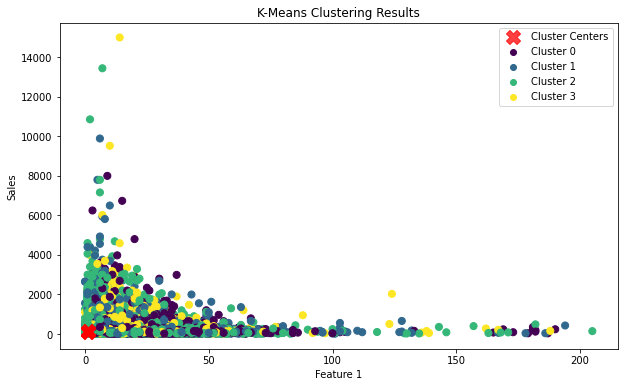

In [115]:
best_kmeans = KMeans(**grid_search.best_params_)
best_kmeans.fit(X)

labels = best_kmeans.labels_

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 23], X[:, 22], c=labels, s=50, cmap='viridis')

# Scatter plot for cluster centers
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], 
            c='red', s=200, alpha=0.75, marker='X', label='Cluster Centers')

# Adding a legend for clusters
unique_labels = set(labels)
for label in unique_labels:
    # Create an empty scatter plot for each cluster to add to the legend
    plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}')

# Add titles and labels
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Sales')

# Show the legend
plt.legend()
plt.show()

### 4. Evaluation

**Silhouette Score**

> The silhouette score is used to assess the quality of clustering results. This metric measures how well each data point is clustered with other points in the same cluster compared to points in different clusters.

Silhouette score range is from -1 to 1
* 1: Indicates that the point is very well clustered (far from the neighboring cluster).
* 0: Indicates that the point is on or very close to the decision boundary between two neighboring clusters.
* Negative Values: Indicate that the point may be placed in the wrong cluster, as it is closer to a neighboring cluster than its own.
* Positive Values: Indicate that the point placed in the right cluster, as it is closer to its own cluster

Interpretation
* High Score ( 0.5 - 1.0 ): A higher average silhouette score suggests that the clusters are well-defined, with points being closer to their own cluster than to others.
* Moderate Score ( 0.2 - 0.5 ): This indicates some overlap between clusters, but the clustering is still acceptable.
* Low Score ( 0.0 - 0.2 ): This suggests poor clustering, as many points lie on the boundary between clusters.
* Negative Score ( -1.0 - 0.0 ): Indicates very poor clustering, where points may be misclassified into the wrong cluster.

In [70]:
# Hitung silhouette score untuk model terbaik
silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5992473866262993


A silhouette score of 0.5992 indicates a relatively good quality of clustering. This score is above the 0.5 threshold, suggesting that the clusters are fairly well-defined and that points are closer to their own cluster than to neighboring clusters.